# Определение возраста покупателей

## Исследовательский анализ данных

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Посмотрим на размер выборки - у нас есть 7591 изображение людей (предположительно, разных).

Построим график распределения возраста в выборке.

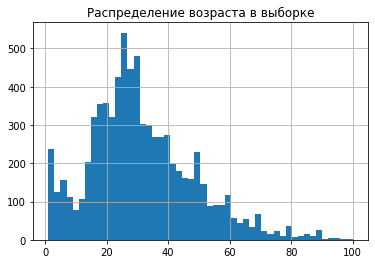

In [3]:
labels['real_age'].hist(bins = 50)
plt.title('Распределение возраста в выборке')
plt.show()

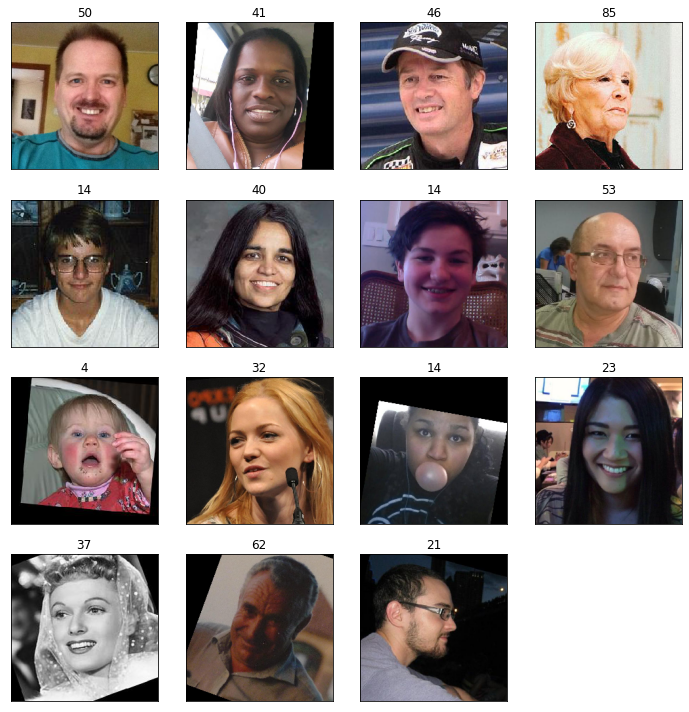

In [4]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы**:
    
- Датасет относительно небольшой (всего 7591 изображение), а значит стоит увеличить выборку изображений для повышения качества итоговой модели. 

- Мы видим также, что изображения очень разные: в разном освещение, под разными углами и с разными выражениями лиц, на некоторых лицо человека загораживают посторонние предметы, а некоторые фотографии черно-белые. Все это может усложнить обучение модели.

- Возраст (целевой признак) в выборке распредлен неравномерно - большая часть фотографий принадлежит людям от 20 до 30 лет, практически не представлены люди старше 60 и дети ~10 лет (при этом почему-то сравнительно много детей младшего возраста). Наша модель будет лучше распознавать людей самого частого в датасете возраста и, скорее всего, будет чаще ошибаться на менее представленных. Чтобы понять, насколько это будет важно в реальном использовании модели, нужно примерно представлять целевую аудиторию супермаркета. Однако уже сейчас можно сказать, что покупателей старше 60 лет скорее всего будет пропорциональном меньше и в реальности в силу меньшей мобильности этой группы, при этом группа от 16 до 30 как раз самая актуальная для второй задачи (проверка добросоветсности кассиров при продаже алкоголя), так как именно в этой категории можно ошибиться с оценкой возраста покупателя "на глаз".

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    
	labels = pd.read_csv(path + 'labels.csv')
	train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
                                  horizontal_flip=True)
	train_datagen_flow = train_datagen.flow_from_dataframe(
	dataframe=labels,
	directory= path + 'final_files/',
	x_col='file_name',
	y_col='real_age',
	target_size=(224, 224),
	batch_size=32,
	class_mode='raw',
	subset = 'training',
	seed=12345)
    
	return train_datagen_flow

def load_test(path):
    
	labels = pd.read_csv(path + 'labels.csv')
	test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)
	test_datagen_flow = test_datagen.flow_from_dataframe(
	dataframe=labels,
	directory= path + 'final_files/',
	x_col='file_name',
	y_col='real_age',
	target_size=(224, 224),
	batch_size=32,
	class_mode='raw',
	subset = 'validation',
	seed=12345)
    
	return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights= 'imagenet')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=1, activation='relu', kernel_regularizer = 'l2'))
    optimize = Adam(learning_rate = 0.0004)
    model.compile(optimizer=optimize, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model 


def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None,
                epochs=15, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_datagen_flow)

    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              epochs=epochs, verbose=2)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/15
2023-09-01 13:25:58.788135: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-01 13:25:59.229274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 70s - loss: 180.8741 - mean_absolute_error: 9.9825 - val_loss: 470.7936 - val_mean_absolute_error: 16.6099
Epoch 2/15
178/178 - 40s - loss: 100.0238 - mean_absolute_error: 7.5785 - val_loss: 474.7726 - val_mean_absolute_error: 16.6815
Epoch 3/15
178/178 - 48s - loss: 79.0646 - mean_absolute_error: 6.7382 - val_loss: 474.4926 - val_mean_absolute_error: 16.5837
Epoch 4/15
178/178 - 51s - loss: 61.7559 - mean_absolute_error: 5.9189 - val_loss: 221.4676 - val_mean_absolute_error: 11.8581
Epoch 5/15
178/178 - 50s - loss: 49.8333 - mean_absolute_error: 5.3680 - val_loss: 94.1655 - val_mean_absolute_error: 7.3781
Epoch 6/15
178/178 - 47s - loss: 37.9242 - mean_absolute_error: 4.7226 - val_loss: 89.4388 - val_mean_absolute_error: 7.1734
Epoch 7/15
178/178 - 43s - loss: 30.8789 - mean_absolute_error: 4.2336 - val_loss: 82.8176 - val_mean_absolute_error: 6.7885
Epoch 8/15
178/178 - 42s - loss: 25.8731 - mean_absolute_error: 3.8736 - val_loss: 113.6021 - val_mean_absolute_error: 8.3527
Epoch 9/15
178/178 - 39s - loss: 21.8059 - mean_absolute_error: 3.5744 - val_loss: 86.0014 - val_mean_absolute_error: 7.1172
Epoch 10/15
178/178 - 41s - loss: 18.1906 - mean_absolute_error: 3.2716 - val_loss: 76.6637 - val_mean_absolute_error: 6.4855
Epoch 11/15
178/178 - 50s - loss: 16.1618 - mean_absolute_error: 3.0558 - val_loss: 75.1586 - val_mean_absolute_error: 6.4547
Epoch 12/15
178/178 - 49s - loss: 14.7252 - mean_absolute_error: 2.9198 - val_loss: 70.6451 - val_mean_absolute_error: 6.3904
Epoch 13/15
178/178 - 51s - loss: 14.3629 - mean_absolute_error: 2.9317 - val_loss: 99.2688 - val_mean_absolute_error: 7.3177
Epoch 14/15
178/178 - 47s - loss: 13.8268 - mean_absolute_error: 2.8390 - val_loss: 67.7263 - val_mean_absolute_error: 6.1877
Epoch 15/15
178/178 - 43s - loss: 12.4594 - mean_absolute_error: 2.6772 - val_loss: 65.8988 - val_mean_absolute_error: 6.1058
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 67.0000 - mean_absolute_error: 6.1444

```

## Анализ обученной модели

Выводы по модели:
- с учетом итоговой MAE модели на тестовой выборке (6.1058) мы, скорее всего, сможем использовать ее для формирования персональных рекомендаций для покупателей, так как с большой вероятностью "угадаем" его примерную возрастную группу
- при этом использовать модель для проверки добросовестности кассиров при продаже алкоголя стоит с большой осторожностью, так как здесь ошибка +-6 лет как раз играет довольно большую роль

**Как можно было бы улучшить модель**: 
- Собрать побольше данных именно с помощью камер магазинов этой сети с ее настоящими пользователями - так модель "переобучиться" конкретно под эту задачу (ее нельзя будет использовать для других сетей, но в этой она будет точнее)
- Попробовать превратить задачу регрессии в задачу классификации (осмысленно выделить несколько возрастных групп-классов на основе маркетинговых исследований)